# 时序分析 沪市指数预测

(6893, 2)
            Timestamp   Price
Timestamp                    
1990-12-19 1990-12-19   96.05
1990-12-20 1990-12-20  104.30
1990-12-21 1990-12-21  109.07
1990-12-24 1990-12-24  113.57
1990-12-25 1990-12-25  120.09


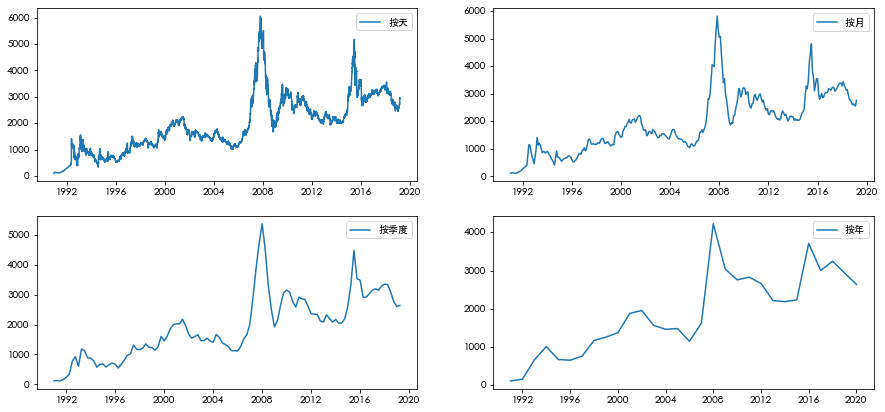

参数错误 (0, 2)
最优模型：                              ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  339
Model:                     ARMA(2, 2)   Log Likelihood               -2208.110
Method:                       css-mle   S.D. of innovations            162.159
Date:                Mon, 26 Oct 2020   AIC                           4428.219
Time:                        12:00:31   BIC                           4451.175
Sample:                    12-31-1990   HQIC                          4437.367
                         - 02-28-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1840.2638    489.711      3.758      0.000     880.447    2800.080
ar.L1.Price     0.5137      0.130      3.959      0.000       0.259       0.768
ar.L2.Price     0.4501      0.1

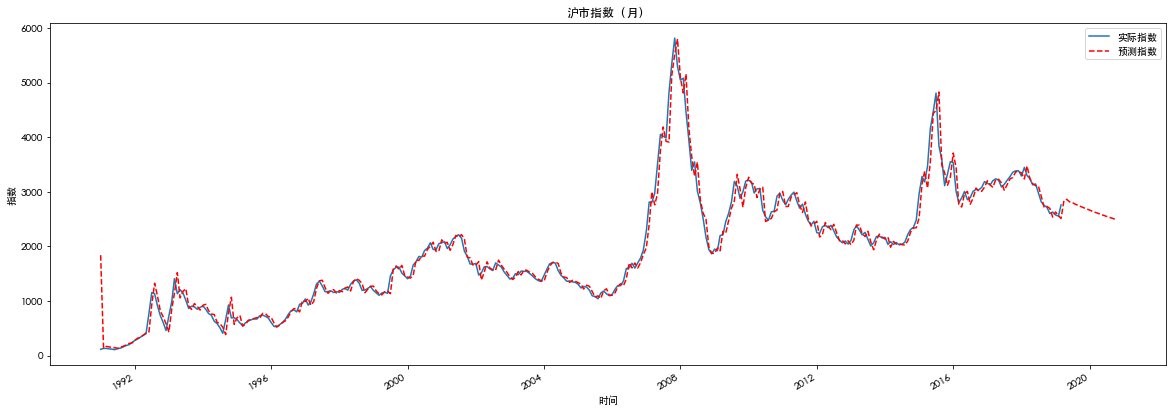

In [1]:
'''
    沪市指数预测，使用时间序列 ARMA 模型预测
'''
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from itertools import product

# 数据加载
df = pd.read_csv('./shanghai_1990-12-19_to_2019-2-28.csv')

# 将时间作为 df 的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp

# 数据探索
print(df.shape)
print(df.head())

# 重新采样，按照 月、季度、年 来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
# 按照 天、月、季度、年来展示比特币的走势 比对

# 设置plt，正确显示中文
plt.rcParams['font.family']='Heiti TC'
plt.rcParams['axes.unicode_minus']=False
fig = plt.figure(figsize=[15, 7])
plt.subplot(221)
plt.plot(df.Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='按年')
plt.legend()
plt.show()

# 设置 ARMA 阶数，p 阶自回归模型、q 阶移动平均模型
ps = range(0,3)
qs = range(0,3)
parameters = product(ps, qs) # 迭代化
parameters_list = list(parameters)
# 寻找最优 ARMA 模型 参数，即 best_aic 最小
results = []
best_aic = float('inf') # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Price, order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

# 输出最优模型
result_tabel = pd.DataFrame(results)
result_tabel.columns = ['parameters', 'aic']
print(f'最优模型：{best_model.summary()}')

# 沪市指数预测
df_month2 = df_month[['Price']]
data_list = pd.date_range('20190228', '20200930', freq='M')
future = pd.DataFrame(index=data_list, columns=df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=len(df_month2['Price']))
# 沪市指数预测结果展示
plt.figure(figsize=(20,7))
df_month2.Price.plot(label='实际指数')
df_month2.forecast.plot(color='r', ls='--', label='预测指数')
plt.legend()
plt.title('沪市指数（月）')
plt.xlabel('时间')
plt.ylabel('指数')
plt.show()

In [3]:
df_month2.to_csv('./预测数据结果.csv', float_format='%.2f')